In [1]:
import os
import pickle
import numpy as np
import tensorflow as tf
from tensorflow.python.estimator.export.export_output import PredictOutput

tf.logging.set_verbosity(tf.logging.INFO)

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def unpickle(file):
    import cPickle
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo)
    return dict

train_data = np.empty([0,32,32,3])
train_labels = np.empty([0])

for i in range(1,6):
    path = os.path.join(os.getcwd(), 'cifar-10-batches-py/data_batch_' + str(i))
    batch = unpickle(path)
    images = batch['data'].reshape(10000,3,32,32)
    train_data = np.append(train_data, np.transpose(images, (0, 2, 3, 1)), axis=0)
    labels = np.asarray(batch['labels'])
    train_labels = np.append(train_labels, labels)
    
path = os.path.join(os.getcwd(), 'cifar-10-batches-py/test_batch')
batch = unpickle(path)
images = batch['data'].reshape(10000,3,32,32)
eval_data = np.transpose(images, (0, 2, 3, 1))
eval_labels = np.asarray(batch['labels']).astype(dtype=np.int32)
train_labels = train_labels.astype(dtype=np.int32)

train_data= np.true_divide(train_data,256).astype(dtype=np.float32)
eval_data= np.true_divide(eval_data,256).astype(dtype=np.float32)

print('train_data shape:   ' + str(train_data.shape) + str(train_data.dtype))
print('train_labels shape: ' + str(train_labels.shape) + str(train_labels.dtype))

print('eval_data shape:    ' + str(eval_data.shape) + str(eval_data.dtype))
print('eval_labels shape:  ' + str(eval_labels.shape) + str(eval_labels.dtype))

train_data shape:   (50000, 32, 32, 3)float32
train_labels shape: (50000,)int32
eval_data shape:    (10000, 32, 32, 3)float32
eval_labels shape:  (10000,)int32


In [3]:
def cnn_model_fn(features, labels, mode):
    """Model function for CNN."""

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=features["x"],
        filters=20,
        kernel_size=3,
        padding="valid",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=2, strides=2)

    # Convolutional Layer #2
    conv2 = tf.layers.conv2d(
        inputs=pool1,
        filters=50,
        kernel_size=2,
        padding="valid",
        activation=tf.nn.relu)

    # Pooling Layer #2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=2, strides=2)
    
    # Convolutional Layer #3
    conv3 = tf.layers.conv2d(
        inputs=pool2,
        filters=200,
        kernel_size=1,
        padding="valid",
        activation=tf.nn.relu)

    # Pooling Layer #3
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=2, strides=2)
    
    # Dense Layer
    pool3_flat = tf.reshape(pool3, [-1, 3 * 3 * 200])
    dense = tf.layers.dense(inputs=pool3_flat, units=2048, activation=tf.nn.relu)
    dense1 = tf.layers.dense(inputs=dense, units=1024, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
        inputs=dense1, rate=0.4, training=mode == tf.estimator.ModeKeys.TRAIN)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)

    predictions = {
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="softmax_tensor")
    }
    
    export_outputs={"SIGNATURE_NAME": PredictOutput({
        # Generate predictions (for PREDICT and EVAL mode)
        "classes": tf.argmax(input=logits, axis=1),
        # Add `softmax_tensor` to the graph. It is used for PREDICT and by the
        # `logging_hook`.
        "probabilities": tf.nn.softmax(logits, name="final_result")
    })}
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions,export_outputs=export_outputs)

    # Calculate Loss (for both TRAIN and EVAL modes)
    loss = tf.losses.sparse_softmax_cross_entropy(labels=labels, logits=logits)

    # Configure the Training Op (for TRAIN mode)
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.AdamOptimizer()
        train_op = optimizer.minimize(
            loss=loss,
            global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op=train_op)

    # Add evaluation metrics (for EVAL mode)
    eval_metric_ops = {
        "accuracy": tf.metrics.accuracy(
            labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(
        mode=mode, loss=loss, eval_metric_ops=eval_metric_ops)

In [4]:
# Create the Estimator
mnist_classifier = tf.estimator.Estimator(
    model_fn=cnn_model_fn, model_dir="./logdir")

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_train_distribute': None, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f045a750dd0>, '_evaluation_master': '', '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_num_ps_replicas': 0, '_tf_random_seed': None, '_master': '', '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_model_dir': './logdir', '_global_id_in_cluster': 0, '_save_summary_steps': 100}


In [5]:
# Set up logging for predictions
tensors_to_log = {"probabilities": "final_result"}
logging_hook = tf.train.LoggingTensorHook(
    tensors=tensors_to_log, every_n_iter=50)

In [6]:
# Train the model
train_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": train_data},
    y=train_labels,
    batch_size=256,
    num_epochs=None,
    shuffle=True)

mnist_classifier.train(
    input_fn=train_input_fn,
    steps=20000,
    hooks=[logging_hook])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ./logdir/model.ckpt.
INFO:tensorflow:probabilities = [[0.10265134 0.11291622 0.10305246 ... 0.09297432 0.09088951 0.09693856]
 [0.10213008 0.10453596 0.0979623  ... 0.09048823 0.09425786 0.10593332]
 [0.11486299 0.1177379  0.11286186 ... 0.08238779 0.0836368  0.0878586 ]
 ...
 [0.11486916 0.09922528 0.09379857 ... 0.09217717 0.08723268 0.09350159]
 [0.10354891 0.10102844 0.10117193 ... 0.09962542 0.08654056 0.1003406 ]
 [0.10106912 0.11709938 0.09977045 ... 0.09289063 0.09297393 0.09417931]]
INFO:tensorflow:loss = 2.3099778, step = 0
INFO:tensorflow:probabilities = [[0.02109059 0.01104866 0.13815457 ... 0.13436696 0.01433071 0.00976699]
 [0.1513895  0.13732001 0.06186017 ... 0.03257821 0.26912332 0.11932234]

INFO:tensorflow:loss = 0.91479725, step = 700 (2.445 sec)
INFO:tensorflow:probabilities = [[0.3239075  0.23980811 0.01792584 ... 0.0018875  0.1679212  0.23054495]
 [0.00082205 0.0001756  0.00645902 ... 0.948791   0.00004585 0.00069089]
 [0.00290492 0.00458233 0.00392164 ... 0.01958635 0.00879826 0.00096381]
 ...
 [0.00142512 0.00048776 0.20953858 ... 0.02347773 0.00019093 0.00090408]
 [0.00572925 0.00111809 0.03125883 ... 0.07234182 0.00143376 0.00422321]
 [0.02481313 0.00075537 0.48045996 ... 0.00956905 0.00076304 0.00054283]] (1.221 sec)
INFO:tensorflow:global_step/sec: 41.027
INFO:tensorflow:probabilities = [[0.0085872  0.00076897 0.20123965 ... 0.04140826 0.00039831 0.00319073]
 [0.0007104  0.00005319 0.02780323 ... 0.01128921 0.00031909 0.0001144 ]
 [0.19813457 0.04984655 0.00200104 ... 0.00075488 0.6837481  0.06344762]
 ...
 [0.12988557 0.00515619 0.84126574 ... 0.00066339 0.0004829  0.0005675 ]
 [0.0006986  0.00070817 0.02607609 ... 0.01452661 0.00039567 0.00032423]
 [0.02042531

INFO:tensorflow:loss = 0.67110604, step = 1500 (2.439 sec)
INFO:tensorflow:probabilities = [[0.00009734 0.0000023  0.09355389 ... 0.01568062 0.00004003 0.00001207]
 [0.00001107 0.00008344 0.00299833 ... 0.00511922 0.00000826 0.00001748]
 [0.00327997 0.68897814 0.00002964 ... 0.00025657 0.00048125 0.30612168]
 ...
 [0.00026322 0.01957511 0.00006639 ... 0.00004255 0.9791555  0.00054002]
 [0.00009853 0.00000531 0.00074394 ... 0.9085094  0.00000028 0.00001595]
 [0.00081649 0.00024051 0.00236599 ... 0.00002509 0.98572046 0.00027591]] (1.210 sec)
INFO:tensorflow:global_step/sec: 41.1335
INFO:tensorflow:probabilities = [[0.00297513 0.00016917 0.00791769 ... 0.00314568 0.00028555 0.00076817]
 [0.00005257 0.00005966 0.01900454 ... 0.11172424 0.00001643 0.00035498]
 [0.48176533 0.00680373 0.00138987 ... 0.00011164 0.5055256  0.0031006 ]
 ...
 [0.00355949 0.00161196 0.01330037 ... 0.19686201 0.00136929 0.01324641]
 [0.06543681 0.00022592 0.65876746 ... 0.00038011 0.002465   0.00099937]
 [0.000012

INFO:tensorflow:loss = 0.25406316, step = 2300 (2.434 sec)
INFO:tensorflow:probabilities = [[0.04428174 0.85533065 0.00153481 ... 0.00041469 0.01542217 0.0824185 ]
 [0.96386534 0.03589689 0.00002174 ... 0.00000005 0.00004731 0.00016448]
 [0.00413616 0.00003451 0.11083619 ... 0.02294241 0.00051859 0.00055609]
 ...
 [0.00059467 0.00146217 0.00026301 ... 0.00172876 0.00143847 0.9794875 ]
 [0.00020225 0.00012857 0.00827317 ... 0.00021151 0.00000605 0.00002938]
 [0.00026545 0.00018767 0.02886126 ... 0.01647156 0.00051586 0.00482431]] (1.225 sec)
INFO:tensorflow:global_step/sec: 40.9356
INFO:tensorflow:probabilities = [[0.99216604 0.00000007 0.00181411 ... 0.00000105 0.00000035 0.00000054]
 [0.00000098 0.00000001 0.00014382 ... 0.06865425 0.         0.0000003 ]
 [0.00419433 0.00082083 0.8881926  ... 0.00095425 0.00021295 0.00071947]
 ...
 [0.02905151 0.0000267  0.05093845 ... 0.00132213 0.00002145 0.00002283]
 [0.00000052 0.00000008 0.00248645 ... 0.00052417 0.00000001 0.00000019]
 [0.      

INFO:tensorflow:loss = 0.10809685, step = 3100 (2.428 sec)
INFO:tensorflow:probabilities = [[0.99978405 0.00000002 0.0000024  ... 0.         0.00021338 0.00000005]
 [0.         0.00000001 0.00000003 ... 0.00000072 0.         0.00000016]
 [0.         0.0000701  0.         ... 0.         0.         0.9999299 ]
 ...
 [0.00000003 0.00000056 0.00000026 ... 0.00000012 0.00000004 0.00000052]
 [0.00000177 0.00000105 0.00196643 ... 0.02024897 0.00000008 0.00006192]
 [0.         0.00001517 0.         ... 0.         0.         0.99998486]] (1.214 sec)
INFO:tensorflow:global_step/sec: 41.1734
INFO:tensorflow:probabilities = [[0.00000006 0.         0.00761771 ... 0.00003984 0.00000004 0.00000013]
 [0.         0.         0.00000209 ... 0.         0.         0.        ]
 [0.00000967 0.         0.99999034 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.00001696 ... 0.00044459 0.         0.        ]
 [0.00000947 0.99939835 0.         ... 0.         0.00050644 0.00008527]
 [0.999877

INFO:tensorflow:loss = 0.05281718, step = 3900 (2.487 sec)
INFO:tensorflow:probabilities = [[0.         0.00000088 0.9993862  ... 0.00000081 0.00000013 0.00001576]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.00000001 0.0083167  ... 0.00000263 0.         0.00000001]
 [0.         0.         0.         ... 0.9989635  0.         0.00000006]
 [0.00000952 0.00000015 0.96751493 ... 0.00000622 0.00000012 0.00010943]] (1.220 sec)
INFO:tensorflow:global_step/sec: 40.8173
INFO:tensorflow:probabilities = [[0.00000002 0.         0.         ... 0.00042641 0.         0.        ]
 [0.00080706 0.9991623  0.00000002 ... 0.00000005 0.00000435 0.0000261 ]
 [0.         0.         0.00000005 ... 0.9832909  0.         0.        ]
 ...
 [0.00218487 0.00000291 0.         ... 0.00000001 0.9082781  0.08951808]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.997721

INFO:tensorflow:loss = 0.07515459, step = 4700 (2.467 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00076112 ... 0.00000152 0.00000001 0.0000001 ]
 [0.         0.         0.00000348 ... 0.9996723  0.         0.        ]
 [0.9998512  0.         0.00000003 ... 0.         0.0001487  0.        ]
 ...
 [0.         0.         0.00000283 ... 0.00000076 0.         0.        ]
 [0.00000004 0.         0.0000087  ... 0.0000312  0.         0.        ]
 [0.00027559 0.00000254 0.14816418 ... 0.64217246 0.00000019 0.00000638]] (1.223 sec)
INFO:tensorflow:global_step/sec: 40.8607
INFO:tensorflow:probabilities = [[0.00000007 0.         0.00025117 ... 0.00000121 0.00000031 0.        ]
 [0.00000505 0.00000376 0.         ... 0.00000086 0.9997305  0.00025978]
 [0.00000401 0.00000009 0.00001638 ... 0.00036048 0.         0.00000254]
 ...
 [0.         0.         0.00001787 ... 0.00013451 0.         0.00000001]
 [0.00000021 0.9999994  0.         ... 0.         0.0000001  0.00000027]
 [0.000004

INFO:tensorflow:loss = 0.021294305, step = 5500 (2.455 sec)
INFO:tensorflow:probabilities = [[0.00000034 0.9999635  0.         ... 0.         0.         0.0000361 ]
 [0.00000001 0.         0.00000098 ... 0.00000297 0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 ...
 [0.9999696  0.         0.         ... 0.         0.00003034 0.00000001]
 [0.9999999  0.         0.         ... 0.         0.         0.        ]
 [0.00000002 0.         0.         ... 0.00000005 0.         0.        ]] (1.229 sec)
INFO:tensorflow:global_step/sec: 40.6934
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.9999751  0.         0.        ]
 [0.00000001 0.00000002 0.         ... 0.00000017 0.         0.99999976]
 [0.         0.00000002 0.0009559  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.9999999  0.0000001 ]
 [0.         0.         0.9999999  ... 0.         0.         0.00000003]
 [0.00000

INFO:tensorflow:loss = 0.03282806, step = 6300 (2.455 sec)
INFO:tensorflow:probabilities = [[0.00000201 0.         0.00042623 ... 0.00000046 0.         0.00000003]
 [0.         0.         0.         ... 0.         0.         0.00001188]
 [0.         0.         0.         ... 0.         0.         0.99999785]
 ...
 [0.         0.         0.00000476 ... 0.00000001 0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.00000041 ... 0.9999894  0.         0.        ]] (1.214 sec)
INFO:tensorflow:global_step/sec: 40.9023
INFO:tensorflow:probabilities = [[0.         0.         0.00002079 ... 0.00000004 0.         0.        ]
 [0.00000962 0.         0.99999034 ... 0.         0.         0.        ]
 [0.00019635 0.00000134 0.00019167 ... 0.00100442 0.00029665 0.0000004 ]
 ...
 [0.00000587 0.         0.00000022 ... 0.         0.9999939  0.        ]
 [0.00000001 0.99999475 0.         ... 0.         0.00000004 0.00000516]
 [0.      

INFO:tensorflow:loss = 0.057836626, step = 7100 (2.445 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.00000004 ... 0.00110595 0.         0.        ]
 [0.9999558  0.00000016 0.         ... 0.00000004 0.00002316 0.00001935]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.00002112 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.00000055 ... 0.00000001 0.00000102 0.        ]] (1.229 sec)
INFO:tensorflow:global_step/sec: 40.7442
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000001 0.9990859  0.00068548 ... 0.00000211 0.00000174 0.00003911]
 ...
 [0.00000007 0.         0.         ... 0.         0.9994879  0.00051199]
 [0.0000075  0.         0.00010993 ... 0.00004571 0.00000016 0.00000002]
 [0.00000

INFO:tensorflow:loss = 0.0037008969, step = 7900 (2.445 sec)
INFO:tensorflow:probabilities = [[0.         0.00000036 0.         ... 0.         0.99999964 0.        ]
 [0.9999999  0.         0.00000011 ... 0.         0.         0.        ]
 [0.         0.00000024 0.         ... 0.         0.         0.        ]
 ...
 [0.         0.99982625 0.         ... 0.00000017 0.00000004 0.00000103]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (1.226 sec)
INFO:tensorflow:global_step/sec: 40.783
INFO:tensorflow:probabilities = [[0.         0.00000003 0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000002 0.00000001 0.99945337 ... 0.00000028 0.00000001 0.        ]
 ...
 [0.         0.         0.         ... 0.00000001 0.         1.        ]
 [0.         0.         0.         ... 0.00000175 0.         0.        ]
 [0.00001

INFO:tensorflow:loss = 0.026808657, step = 8700 (2.484 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         1.         0.        ]
 [0.99750876 0.00000022 0.00006365 ... 0.00007814 0.00227653 0.00001572]
 [0.         0.         0.         ... 0.00000146 0.         0.00000006]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000013 0.00000026 0.00092439 ... 0.00009209 0.00000463 0.00000012]] (1.241 sec)
INFO:tensorflow:global_step/sec: 40.6746
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         1.        ]
 [0.9999949  0.00000507 0.00000002 ... 0.         0.         0.00000004]
 [0.         0.         0.99999785 ... 0.         0.00000084 0.        ]
 ...
 [0.00009625 0.         0.00010363 ... 0.0000001  0.00002074 0.00000102]
 [0.         0.         0.00000002 ... 0.0000005  0.         0.00000001]
 [0.     

INFO:tensorflow:loss = 0.08533092, step = 9500 (2.427 sec)
INFO:tensorflow:probabilities = [[0.00000013 0.         0.         ... 0.00000002 0.         0.        ]
 [0.00000001 0.         0.         ... 0.         0.9999999  0.00000011]
 [0.         0.         0.         ... 0.         1.         0.        ]
 ...
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.00000118 0.00000006 0.         ... 0.00000002 0.         0.9999987 ]
 [0.         0.         0.00000063 ... 0.         0.         0.00000004]] (1.216 sec)
INFO:tensorflow:global_step/sec: 41.0694
INFO:tensorflow:probabilities = [[0.00000003 0.00001958 0.00021884 ... 0.9515769  0.00000006 0.00000334]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.00000001 0.         ... 0.         0.         1.        ]
 ...
 [0.88600343 0.         0.00000833 ... 0.         0.11398268 0.00000322]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.      

INFO:tensorflow:loss = 0.020972915, step = 10300 (2.443 sec)
INFO:tensorflow:probabilities = [[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.9999995  0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000086 0.00037222 0.00008224 ... 0.00000793 0.9953857  0.00000056]] (1.228 sec)
INFO:tensorflow:global_step/sec: 40.8704
INFO:tensorflow:probabilities = [[0.0000001  0.         0.9835836  ... 0.0140743  0.         0.0000219 ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.9999999  0.         ... 0.         0.         0.00000006]
 [0.    

INFO:tensorflow:loss = 0.008287122, step = 11100 (2.435 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.99975973 ... 0.         0.         0.        ]
 [1.         0.         0.00000003 ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]] (1.217 sec)
INFO:tensorflow:global_step/sec: 40.8548
INFO:tensorflow:probabilities = [[0.00000064 0.         0.00000001 ... 0.         0.9999993  0.        ]
 [0.         0.         0.00052003 ... 0.00000557 0.         0.00000005]
 [0.         0.         0.         ... 0.         1.         0.        ]
 ...
 [0.00000152 0.00000036 0.99394834 ... 0.00000037 0.00000001 0.000005  ]
 [0.         0.9999826  0.         ... 0.         0.00000025 0.00001714]
 [0.9999

INFO:tensorflow:loss = 0.031604033, step = 11900 (2.446 sec)
INFO:tensorflow:probabilities = [[0.00001217 0.00000301 0.00000001 ... 0.00000001 0.00000001 0.        ]
 [0.         0.         0.00000003 ... 0.9999931  0.         0.00000033]
 [0.         0.         0.00000077 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000001 0.9999999  0.         ... 0.         0.         0.00000008]
 [0.00012523 0.         0.         ... 0.         0.9998747  0.        ]] (1.215 sec)
INFO:tensorflow:global_step/sec: 41.0575
INFO:tensorflow:probabilities = [[0.         0.         0.00001693 ... 0.         0.         0.        ]
 [0.997658   0.         0.00234199 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.00000146 0.         0.         ... 0.         0.99999857 0.        ]
 [0.00000013 0.00006927 0.         ... 0.         0.00247953 0.997451  ]
 [0.0000

INFO:tensorflow:loss = 0.012600599, step = 12700 (2.443 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.00000064 0.00000007 0.00989508 ... 0.         0.00000306 0.        ]
 ...
 [0.         0.         0.00000009 ... 0.         0.         0.        ]
 [0.         0.         0.00024573 ... 0.         0.         0.        ]
 [0.         0.00000005 0.         ... 0.         0.         0.        ]] (1.218 sec)
INFO:tensorflow:global_step/sec: 40.9878
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 1.         0.         0.        ]
 [0.00000003 0.         0.00017626 ... 0.99981827 0.         0.00000522]
 [0.         0.         0.00000688 ... 0.00000003 0.00000555 0.        ]
 ...
 [0.         0.         0.21941054 ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.    

INFO:tensorflow:loss = 0.012237454, step = 13500 (2.441 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.99999845 ... 0.         0.         0.        ]
 [0.00000028 0.         0.         ... 0.         0.         0.99999976]
 [0.00000038 0.         0.         ... 0.         0.99999964 0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.00000376 0.00000934 0.         ... 0.         0.99998665 0.        ]
 [0.9999865  0.         0.         ... 0.         0.00001353 0.        ]] (1.229 sec)
INFO:tensorflow:global_step/sec: 40.8067
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 ... 0.         0.         0.        ]
 [0.00000017 0.         0.01356706 ... 0.00000475 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.9999999  ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.9999

INFO:tensorflow:loss = 0.00783571, step = 14300 (2.449 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.00000001]
 [0.         1.         0.         ... 0.         0.         0.        ]
 ...
 [0.9999336  0.0000096  0.00000003 ... 0.00001304 0.         0.00000001]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]] (1.225 sec)
INFO:tensorflow:global_step/sec: 40.7671
INFO:tensorflow:probabilities = [[0.         0.         0.00000002 ... 0.00000001 0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.00000415 0.         0.00000004 ... 0.9965655  0.00000001 0.        ]
 ...
 [0.00000003 0.00000503 0.         ... 0.         0.00189583 0.998099  ]
 [0.00000016 0.00000002 0.         ... 0.00000017 0.00000008 0.9999995 ]
 [0.     

INFO:tensorflow:loss = 0.004463064, step = 15100 (2.448 sec)
INFO:tensorflow:probabilities = [[0.00000001 0.         0.00000969 ... 0.00000295 0.00000001 0.00000074]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]] (1.231 sec)
INFO:tensorflow:global_step/sec: 40.4305
INFO:tensorflow:probabilities = [[0.         0.8759903  0.00003616 ... 0.         0.00000044 0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.0000

INFO:tensorflow:loss = 0.021022122, step = 15900 (2.443 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.00000013 0.         0.9999999  ... 0.         0.         0.        ]
 ...
 [0.         0.         0.0001158  ... 0.00000003 0.         0.        ]
 [0.         0.         0.00043192 ... 0.00000003 0.         0.        ]
 [0.         0.00014966 0.         ... 0.         0.00000008 0.9998349 ]] (1.227 sec)
INFO:tensorflow:global_step/sec: 40.7763
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.999979   0.         0.00000006]
 [0.3784708  0.00000978 0.26525176 ... 0.00000013 0.35468885 0.        ]
 ...
 [0.00001434 0.78723747 0.0000004  ... 0.         0.00003157 0.00000061]
 [0.00000001 0.00000189 0.00013318 ... 0.         0.         0.99984384]
 [0.    

INFO:tensorflow:loss = 0.027408661, step = 16700 (2.450 sec)
INFO:tensorflow:probabilities = [[0.         0.00000002 0.         ... 0.         0.         1.        ]
 [0.         0.         0.9757377  ... 0.         0.         0.        ]
 [0.00002916 0.00000078 0.00010528 ... 0.00015248 0.00000071 0.00001058]
 ...
 [0.         0.         0.         ... 0.00000101 0.         0.79296356]
 [0.         0.         0.         ... 0.00000005 0.         1.        ]
 [0.         0.         0.00002042 ... 0.         0.         0.        ]] (1.230 sec)
INFO:tensorflow:global_step/sec: 40.7843
INFO:tensorflow:probabilities = [[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 [0.         0.         0.99999046 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.    

INFO:tensorflow:loss = 0.038119163, step = 17500 (2.472 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.00000001 0.         0.         ... 1.         0.         0.        ]
 ...
 [0.         0.         0.9999995  ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.00000003 0.00000004 0.         ... 0.         0.9999999  0.        ]] (1.227 sec)
INFO:tensorflow:global_step/sec: 40.8109
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.00013533 0.         0.99307775 ... 0.00000008 0.         0.        ]
 ...
 [0.         0.         0.         ... 0.99999964 0.         0.        ]
 [0.0000007  0.         0.         ... 0.         0.         0.        ]
 [0.    

INFO:tensorflow:loss = 0.015955232, step = 18300 (2.445 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.9939714  0.         0.        ]
 [0.0001677  0.         0.9998323  ... 0.         0.         0.        ]
 [0.         0.99999976 0.         ... 0.         0.         0.00000029]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.9999813  0.00000019 0.         ... 0.         0.         0.00001849]
 [0.         0.         0.00000017 ... 0.99997723 0.         0.        ]] (1.221 sec)
INFO:tensorflow:global_step/sec: 40.7822
INFO:tensorflow:probabilities = [[0.00000836 0.         0.00000011 ... 0.         0.         0.9998393 ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.         0.         0.        ]
 ...
 [0.9994978  0.         0.         ... 0.         0.00050225 0.        ]
 [0.         0.         0.0000001  ... 0.00001994 0.         0.9995826 ]
 [0.    

INFO:tensorflow:loss = 0.02373612, step = 19100 (2.438 sec)
INFO:tensorflow:probabilities = [[0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.00000009 0.         ... 0.00000028 0.99999774 0.00000165]
 ...
 [0.         0.         0.99999297 ... 0.         0.         0.        ]
 [0.00000001 0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.00000007 ... 0.         0.         0.        ]] (1.224 sec)
INFO:tensorflow:global_step/sec: 41.3843
INFO:tensorflow:probabilities = [[0.         0.         0.00000001 ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]
 ...
 [0.         0.         0.00000001 ... 0.         0.         0.        ]
 [0.         0.         0.9999989  ... 0.00000001 0.         0.        ]
 [0.     

INFO:tensorflow:loss = 0.009453725, step = 19900 (2.479 sec)
INFO:tensorflow:probabilities = [[0.         1.         0.         ... 0.         0.         0.        ]
 [0.9999994  0.         0.00000059 ... 0.         0.         0.        ]
 [0.         0.         0.00000003 ... 0.         0.         0.        ]
 ...
 [0.99999964 0.00000031 0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.00000567 0.9999943 ]
 [0.         0.         0.         ... 0.         1.         0.        ]] (1.238 sec)
INFO:tensorflow:Saving checkpoints for 20000 into ./logdir/model.ckpt.
INFO:tensorflow:Loss for final step: 0.008733981.


In [7]:
# Evaluate the model and print results
eval_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"x": eval_data},
    y=eval_labels,
    num_epochs=1,
    shuffle=False)
eval_results = mnist_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-05-23-09:51:41
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-20000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-05-23-09:51:42
INFO:tensorflow:Saving dict for global step 20000: accuracy = 0.694, global_step = 20000, loss = 2.7787514
{'loss': 2.7787514, 'global_step': 20000, 'accuracy': 0.694}


In [8]:
# Export the model to saved_model.pb file
def serving_input_receiver():
    inputs = {"x": tf.placeholder(dtype=tf.float32, shape=[None,32,32,3], name="input")}
    return tf.estimator.export.ServingInputReceiver(inputs, inputs)

export_dir = mnist_classifier.export_savedmodel(
    export_dir_base = "./logdir",
    serving_input_receiver_fn = serving_input_receiver,
    as_text=False)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Signatures INCLUDED in export for Classify: None
INFO:tensorflow:Signatures INCLUDED in export for Regress: None
INFO:tensorflow:Signatures INCLUDED in export for Predict: ['serving_default', 'SIGNATURE_NAME']
INFO:tensorflow:Restoring parameters from ./logdir/model.ckpt-20000
INFO:tensorflow:Assets added to graph.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./logdir/temp-1527069102/saved_model.pb


INFO:tensorflow:Restoring parameters from ./logdir/1527069102/variables/variables
('Class: ', 0)


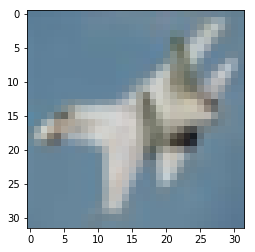

In [9]:
# Evaluate a sample image and display it
import matplotlib.pyplot as plt
from tensorflow.contrib import predictor

%matplotlib inline

image = eval_data[10].reshape(1,32,32,3)

predict_fn = predictor.from_saved_model(export_dir)
predictions = predict_fn({"x": image})

print("Class: ", predictions['classes'][0])

# Reshape the image as a 32x32x3 image
plt.imshow(image.reshape(32, 32, 3));